# Домашнее задание №2

# Метод главных компонент

**Выполнила:** Набережных Дарина Денисовна

**Группа:** НПМбд-01-19

## Получение данных

In [1]:
# Импорт необходимых библиотек
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

Загрузим базу данных *digits*, воспользовавшись функцией *load_digits* 

In [2]:
digits = load_digits()
X = digits['data']
labels = digits['target']

Нарисуем несколько картинок из Х с помощью функции *matplotlib.pyplot.imshow*, при этом воспользуемся *subplots*, чтобы изображения шли в виде массива.

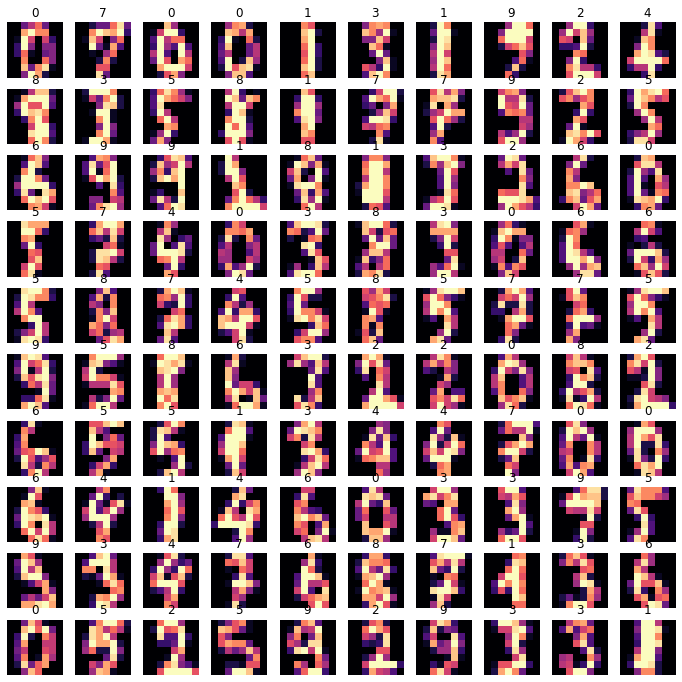

In [3]:
fig, axis = plt.subplots(10,10, figsize=(12,12))
for i in range(10):
    for j in range(10):
        k = np.random.randint(0, 1797)
        axis[i, j].imshow(X[k,:].reshape((8, 8)), cmap='magma') 
        axis[i, j].set_title(labels[k])
        axis[i, j].axis('off')

## Алгоритм РСА

Метод главных компонент состоит из следующих 4-х шагов:  
1. Центрирование данных: $ X_c = X – \overline{X} $, где $ \overline{X} $ – среднее для каждого параметра 
2. Вычисление матрицы ковариации: $ C = X_c^TX_C $ 
3. Вычисление собственных векторов $ F $ и значений $ \lambda $ матрицы ковариации $ C $ 
4. Преобразование данных в координаты в базисе главных компонент: $ Y = X_cF $ 

Реализуем алгоритм РСА в виде класса:

* Метод `init` сохраняет количество компонент *n_components* во внутреннюю переменную *self.n_components*
* Метод `fit`: сначала выполняется центрирование данных, затем вычисляется матрица ковариации и после находятся с.в. *F* и с.з *l* матрицы ковариации *С*
* Метод  `transform`: преобразует данные в координаты в базисе главных компонент

In [4]:
class my_PCA(): 
    def __init__(self, n_components=None):
        self.n_components = n_components    # n_components - кол-во компонент, которое оставляем
    
    def fit(self, X): 
        X_new = X
        mean_X = np.mean(X_new, axis=0)
        Xc = X_new - mean_X    # центрируем данные
        C = np.transpose(Xc).dot(Xc)    # С -матрица ковариации
        l, F = np.linalg.eigh(C)    # l - собственные значения, F - собственные вектора C
        l = l[::-1]
        F = F[:,::-1]
        return Xc, F, l    # Х - центрированные данные
    
    def transform(self, X, F):    # X - центрированные данные, F - с.в.матрицы ков. С
        Y = X.dot(F)    # перемножаем две матрицы
        return Y  
    
    def fit_transform(self, X):
        Xc, F, _ = self.fit(X)    # X - массив картинок
        Y = self.transform(Xc, F)    # Y - решение
        if self.n_components != None:
            Y = Y[:, :(self.n_components)]
        return Y

Построим график собственных значений:

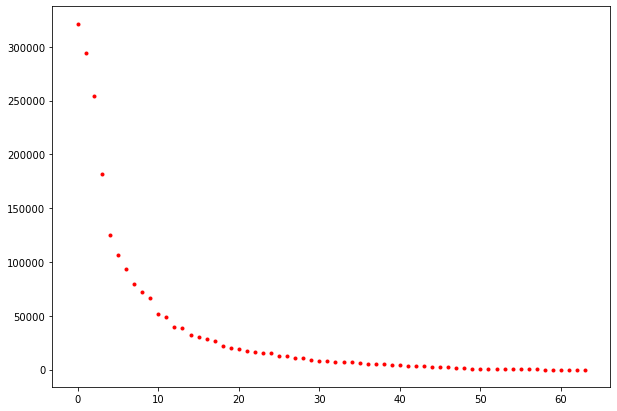

In [5]:
test = my_PCA(2) 
_, _, l = test.fit(X)
plt.figure(figsize=(10,7))
plt.plot(l, marker = '.', linestyle = '', color='red')
plt.show()

Так же построим график отношения кумулятивной суммы к полной сумме:

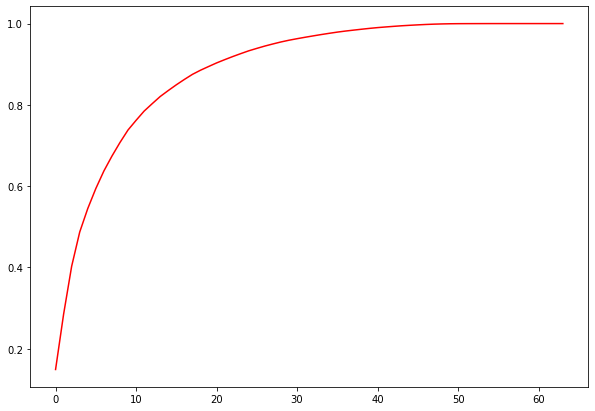

In [6]:
plt.figure(figsize=(10,7))
plt.plot(np.cumsum(l) / np.sum(l), color='red')
plt.show()

Видим, что основную долю вносят первые собственные значения.

Теперь построим график с точками датасета, оставив только 2 главные координаты главных компонент, при этом разным цифрам будут соответствовать разные цвета.

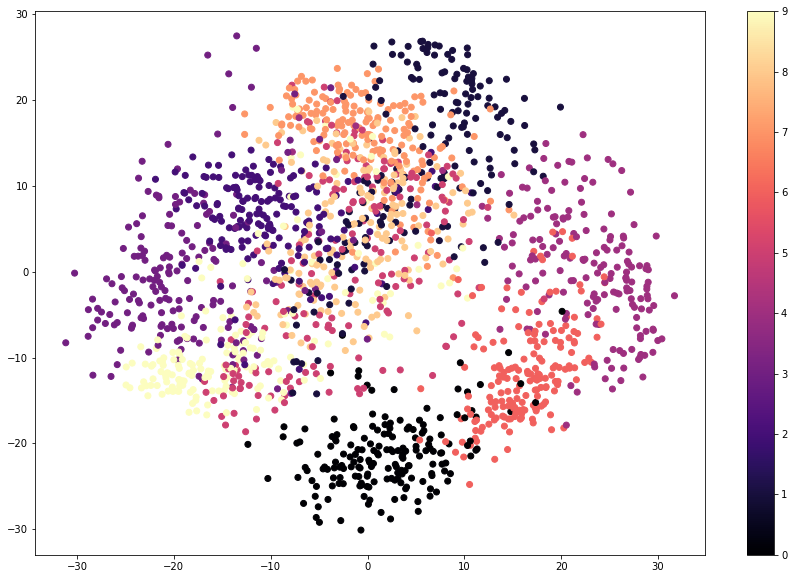

In [7]:
Y = test.fit_transform(X)
plt.figure(figsize=(15,10))
plt.scatter(Y[:,0], Y[:,1], c = labels, cmap = 'magma')
plt.colorbar()
plt.show()

## Алгоритм kNN

Алгоритм k-ближайших соседей (k-nearest neighbours (kNN)) является одним из простейших метрических алгоритмов для решения задач классификации объектов. Суть его в следующем:

Пусть  у нас есть $ X_{train} $ – некоторая  обучающая  выборка  данных  с известными  классами  принадлежности  объектов $ y_{train} $.


Предположим,  есть  некоторый объект $ x_* $  с  неизвестным  классом,  который  мы  хотели  бы  предсказать.  
Посчитаем расстояния от $ x_* $  до каждого из объектов $ X_{train} $ и найдём $ k $ ближайших (т.е. с наименьшим  расстоянием)  из  этого  набора.  


Мы знаем к какому классу принадлежат эти $ k $ соседей, значит, мы  можем предположить, что и наш объект $ x_* $ будет принадлежать к тому классу, из которого наибольшее количество соседей.  

Реализуем алгоритм kNN в виде класса:

* Метод `init` сохраняет *n_neighbors* во внутреннюю переменную *self.n_neighbors*

* Метод `fit` сохраняет переданные обучающие данные *X_train* и *y_train* во внутренние переменные *self.X_train* и *self.y_train*.

* Метод `predict` реализует основные вычисления для каждого неизвестного объекта:
 - Находим для неизвестного объекта расстояние от него до известных/обучающих объектов в многомерном пространстве
 - Находим индексы отсортированных в порядке неубывания расстояний
 - Выбираем из этих индексов первые k штук
 - Сопоставляем полученные индексы с классами объектов и из полученных классов объектов выбираем тот, который встречается чаще всего - это и есть наш искомый класс

In [8]:
class my_kNN():
    
    def __init__(self, n_neighbours = 5):
        self.n_neighbours = n_neighbours
    
    def fit(self, X_train, y_train):
        self.X_train = X_train
        self.y_train = y_train

    def predict(self, X): 
        classes = list()
        
        for point in X:
            distances = list()    # набор расстояний  
            
            for point_train in self.X_train:
                distance = np.linalg.norm(np.array(point) - np.array(point_train))    # ищем расстояние от точки до эл-ов X_train
                distances.append(distance)                
            distances_sort = np.argsort(distances)     
            minimum_distances = distances_sort[:self.n_neighbours]    # выбраем индексы первых k мин.расстояний 
            object_class = list()
            
            for j in minimum_distances:    # сопоставим индексы с классами объектов
                object_class.append(self.y_train[j])
                
            object_class_set = set(object_class)    # поиск класса, который встречается чаще всего
            our_class = None 
            c_our_class = 0
            
            for k in object_class_set:
                c = object_class.count(k)
                if c > c_our_class:
                    c_our_class = c 
                    our_class = k 
            classes.append(our_class)
        return classes

Создадим классификатор *my_kNN* с числом соседей равным 5. Обучим классификатор на обучающих данных. Посчитаем точность на тестовой выборке, используя функцию *accuracy_score* из модуля *sklearn.metrics.*

In [9]:
X_train, X_test, labels_train, labels_test = train_test_split(X, labels, test_size=0.2)
kNN = my_kNN(n_neighbours = 5)
kNN.fit(X_train, labels_train)
labels_pred = kNN.predict(X_test)
print('Точность:', accuracy_score(labels_test, labels_pred) * 100)

Точность: 98.33333333333333


Теперь применим алгоритм ближайших k-соседей к преобразованным данным. Попробуем разное количество соседей (от 1 до 30) и разное количество компонент (начиная с одной и заканчивая всеми 64). 

Найдем параметры, при которых алгоритм даёт наибольшую точность на тестовой выборке. 

In [10]:
for i in range(1, 65):
    print('=' * 40)
    print('Размерность: {}'.format(i))
    PCA = my_PCA(i)
    X_ = PCA.fit_transform(X)
    
    for j in range(1, 31):
        X_train, X_test, labels_train, labels_test = train_test_split(X_, labels, test_size=0.2)
        knn = my_kNN(j) 
        knn.fit(X_train, labels_train)
        print('Точность при {} соседях:'.format(j), (accuracy_score(knn.predict(X_test), labels_test)))
print()

Размерность: 1
Точность при 1 соседях: 0.28888888888888886
Точность при 2 соседях: 0.30277777777777776
Точность при 3 соседях: 0.2916666666666667
Точность при 4 соседях: 0.3194444444444444
Точность при 5 соседях: 0.32222222222222224
Точность при 6 соседях: 0.325
Точность при 7 соседях: 0.34444444444444444
Точность при 8 соседях: 0.35555555555555557
Точность при 9 соседях: 0.3638888888888889
Точность при 10 соседях: 0.3111111111111111
Точность при 11 соседях: 0.35833333333333334
Точность при 12 соседях: 0.35555555555555557
Точность при 13 соседях: 0.30833333333333335
Точность при 14 соседях: 0.325
Точность при 15 соседях: 0.3611111111111111
Точность при 16 соседях: 0.36666666666666664
Точность при 17 соседях: 0.33611111111111114
Точность при 18 соседях: 0.35833333333333334
Точность при 19 соседях: 0.41388888888888886
Точность при 20 соседях: 0.35
Точность при 21 соседях: 0.36944444444444446
Точность при 22 соседях: 0.3416666666666667
Точность при 23 соседях: 0.3527777777777778
Точность 

Точность при 6 соседях: 0.9555555555555556
Точность при 7 соседях: 0.9527777777777777
Точность при 8 соседях: 0.9277777777777778
Точность при 9 соседях: 0.9555555555555556
Точность при 10 соседях: 0.95
Точность при 11 соседях: 0.9527777777777777
Точность при 12 соседях: 0.9611111111111111
Точность при 13 соседях: 0.9638888888888889
Точность при 14 соседях: 0.9472222222222222
Точность при 15 соседях: 0.9361111111111111
Точность при 16 соседях: 0.9194444444444444
Точность при 17 соседях: 0.9222222222222223
Точность при 18 соседях: 0.9333333333333333
Точность при 19 соседях: 0.9333333333333333
Точность при 20 соседях: 0.9222222222222223
Точность при 21 соседях: 0.9361111111111111
Точность при 22 соседях: 0.9388888888888889
Точность при 23 соседях: 0.9388888888888889
Точность при 24 соседях: 0.9416666666666667
Точность при 25 соседях: 0.9388888888888889
Точность при 26 соседях: 0.9333333333333333
Точность при 27 соседях: 0.9305555555555556
Точность при 28 соседях: 0.9305555555555556
Точнос

Точность при 10 соседях: 0.9833333333333333
Точность при 11 соседях: 0.9805555555555555
Точность при 12 соседях: 0.9833333333333333
Точность при 13 соседях: 0.9805555555555555
Точность при 14 соседях: 0.975
Точность при 15 соседях: 0.9611111111111111
Точность при 16 соседях: 0.9555555555555556
Точность при 17 соседях: 0.9583333333333334
Точность при 18 соседях: 0.95
Точность при 19 соседях: 0.9638888888888889
Точность при 20 соседях: 0.9666666666666667
Точность при 21 соседях: 0.9527777777777777
Точность при 22 соседях: 0.9666666666666667
Точность при 23 соседях: 0.9777777777777777
Точность при 24 соседях: 0.9666666666666667
Точность при 25 соседях: 0.9583333333333334
Точность при 26 соседях: 0.9416666666666667
Точность при 27 соседях: 0.9666666666666667
Точность при 28 соседях: 0.9666666666666667
Точность при 29 соседях: 0.9611111111111111
Точность при 30 соседях: 0.9666666666666667
Размерность: 14
Точность при 1 соседях: 0.9694444444444444
Точность при 2 соседях: 0.9722222222222222
Т

Точность при 15 соседях: 0.9777777777777777
Точность при 16 соседях: 0.9805555555555555
Точность при 17 соседях: 0.975
Точность при 18 соседях: 0.9583333333333334
Точность при 19 соседях: 0.9611111111111111
Точность при 20 соседях: 0.9861111111111112
Точность при 21 соседях: 0.9694444444444444
Точность при 22 соседях: 0.9611111111111111
Точность при 23 соседях: 0.975
Точность при 24 соседях: 0.9638888888888889
Точность при 25 соседях: 0.9583333333333334
Точность при 26 соседях: 0.9666666666666667
Точность при 27 соседях: 0.9777777777777777
Точность при 28 соседях: 0.975
Точность при 29 соседях: 0.9638888888888889
Точность при 30 соседях: 0.9611111111111111
Размерность: 20
Точность при 1 соседях: 0.9972222222222222
Точность при 2 соседях: 0.9805555555555555
Точность при 3 соседях: 0.9805555555555555
Точность при 4 соседях: 0.975
Точность при 5 соседях: 0.9861111111111112
Точность при 6 соседях: 0.9861111111111112
Точность при 7 соседях: 0.9805555555555555
Точность при 8 соседях: 0.98888

Точность при 19 соседях: 0.9722222222222222
Точность при 20 соседях: 0.9833333333333333
Точность при 21 соседях: 0.9722222222222222
Точность при 22 соседях: 0.9777777777777777
Точность при 23 соседях: 0.9638888888888889
Точность при 24 соседях: 0.9861111111111112
Точность при 25 соседях: 0.9833333333333333
Точность при 26 соседях: 0.9666666666666667
Точность при 27 соседях: 0.9805555555555555
Точность при 28 соседях: 0.95
Точность при 29 соседях: 0.9722222222222222
Точность при 30 соседях: 0.9694444444444444
Размерность: 26
Точность при 1 соседях: 0.9833333333333333
Точность при 2 соседях: 0.9944444444444445
Точность при 3 соседях: 0.9916666666666667
Точность при 4 соседях: 0.9833333333333333
Точность при 5 соседях: 0.9777777777777777
Точность при 6 соседях: 0.9861111111111112
Точность при 7 соседях: 0.9944444444444445
Точность при 8 соседях: 0.9805555555555555
Точность при 9 соседях: 0.9777777777777777
Точность при 10 соседях: 0.9916666666666667
Точность при 11 соседях: 0.969444444444

Точность при 24 соседях: 0.9638888888888889
Точность при 25 соседях: 0.9694444444444444
Точность при 26 соседях: 0.9638888888888889
Точность при 27 соседях: 0.9722222222222222
Точность при 28 соседях: 0.9472222222222222
Точность при 29 соседях: 0.975
Точность при 30 соседях: 0.9805555555555555
Размерность: 32
Точность при 1 соседях: 0.9916666666666667
Точность при 2 соседях: 0.9888888888888889
Точность при 3 соседях: 0.9888888888888889
Точность при 4 соседях: 0.9944444444444445
Точность при 5 соседях: 0.9833333333333333
Точность при 6 соседях: 0.9861111111111112
Точность при 7 соседях: 0.9722222222222222
Точность при 8 соседях: 0.9805555555555555
Точность при 9 соседях: 0.9861111111111112
Точность при 10 соседях: 0.9861111111111112
Точность при 11 соседях: 0.975
Точность при 12 соседях: 0.9805555555555555
Точность при 13 соседях: 0.9888888888888889
Точность при 14 соседях: 0.9777777777777777
Точность при 15 соседях: 0.9694444444444444
Точность при 16 соседях: 0.9888888888888889
Точност

Точность при 1 соседях: 0.9833333333333333
Точность при 2 соседях: 0.9916666666666667
Точность при 3 соседях: 0.9861111111111112
Точность при 4 соседях: 0.9861111111111112
Точность при 5 соседях: 0.9888888888888889
Точность при 6 соседях: 0.9777777777777777
Точность при 7 соседях: 0.9833333333333333
Точность при 8 соседях: 0.9805555555555555
Точность при 9 соседях: 0.9833333333333333
Точность при 10 соседях: 0.9722222222222222
Точность при 11 соседях: 0.9777777777777777
Точность при 12 соседях: 0.9833333333333333
Точность при 13 соседях: 0.9833333333333333
Точность при 14 соседях: 0.9777777777777777
Точность при 15 соседях: 0.9833333333333333
Точность при 16 соседях: 0.9722222222222222
Точность при 17 соседях: 0.975
Точность при 18 соседях: 0.975
Точность при 19 соседях: 0.9611111111111111
Точность при 20 соседях: 0.9861111111111112
Точность при 21 соседях: 0.975
Точность при 22 соседях: 0.975
Точность при 23 соседях: 0.9666666666666667
Точность при 24 соседях: 0.9722222222222222
Точно

Точность при 8 соседях: 0.9833333333333333
Точность при 9 соседях: 0.9888888888888889
Точность при 10 соседях: 0.975
Точность при 11 соседях: 0.9861111111111112
Точность при 12 соседях: 0.9888888888888889
Точность при 13 соседях: 0.975
Точность при 14 соседях: 0.9722222222222222
Точность при 15 соседях: 0.9805555555555555
Точность при 16 соседях: 0.9722222222222222
Точность при 17 соседях: 0.9722222222222222
Точность при 18 соседях: 0.975
Точность при 19 соседях: 0.9666666666666667
Точность при 20 соседях: 0.9722222222222222
Точность при 21 соседях: 0.975
Точность при 22 соседях: 0.9638888888888889
Точность при 23 соседях: 0.9694444444444444
Точность при 24 соседях: 0.975
Точность при 25 соседях: 0.9583333333333334
Точность при 26 соседях: 0.975
Точность при 27 соседях: 0.9777777777777777
Точность при 28 соседях: 0.9722222222222222
Точность при 29 соседях: 0.9444444444444444
Точность при 30 соседях: 0.9694444444444444
Размерность: 45
Точность при 1 соседях: 0.9833333333333333
Точность 

Точность при 16 соседях: 0.975
Точность при 17 соседях: 0.975
Точность при 18 соседях: 0.9805555555555555
Точность при 19 соседях: 0.9805555555555555
Точность при 20 соседях: 0.9694444444444444
Точность при 21 соседях: 0.9722222222222222
Точность при 22 соседях: 0.9777777777777777
Точность при 23 соседях: 0.9638888888888889
Точность при 24 соседях: 0.9611111111111111
Точность при 25 соседях: 0.9638888888888889
Точность при 26 соседях: 0.9777777777777777
Точность при 27 соседях: 0.9638888888888889
Точность при 28 соседях: 0.9666666666666667
Точность при 29 соседях: 0.9694444444444444
Точность при 30 соседях: 0.9694444444444444
Размерность: 51
Точность при 1 соседях: 0.9916666666666667
Точность при 2 соседях: 0.9888888888888889
Точность при 3 соседях: 0.9916666666666667
Точность при 4 соседях: 0.975
Точность при 5 соседях: 0.9777777777777777
Точность при 6 соседях: 0.9944444444444445
Точность при 7 соседях: 0.9777777777777777
Точность при 8 соседях: 0.9833333333333333
Точность при 9 сосе

Точность при 22 соседях: 0.9666666666666667
Точность при 23 соседях: 0.9666666666666667
Точность при 24 соседях: 0.9666666666666667
Точность при 25 соседях: 0.9666666666666667
Точность при 26 соседях: 0.975
Точность при 27 соседях: 0.9722222222222222
Точность при 28 соседях: 0.9638888888888889
Точность при 29 соседях: 0.975
Точность при 30 соседях: 0.9722222222222222
Размерность: 57
Точность при 1 соседях: 0.9833333333333333
Точность при 2 соседях: 0.9944444444444445
Точность при 3 соседях: 0.9777777777777777
Точность при 4 соседях: 0.9777777777777777
Точность при 5 соседях: 0.9805555555555555
Точность при 6 соседях: 0.9888888888888889
Точность при 7 соседях: 0.9777777777777777
Точность при 8 соседях: 0.9833333333333333
Точность при 9 соседях: 0.9861111111111112
Точность при 10 соседях: 0.9916666666666667
Точность при 11 соседях: 0.9805555555555555
Точность при 12 соседях: 0.9833333333333333
Точность при 13 соседях: 0.9666666666666667
Точность при 14 соседях: 0.9861111111111112
Точност

Точность при 28 соседях: 0.9611111111111111
Точность при 29 соседях: 0.9694444444444444
Точность при 30 соседях: 0.9722222222222222
Размерность: 63
Точность при 1 соседях: 0.9861111111111112
Точность при 2 соседях: 0.9888888888888889
Точность при 3 соседях: 0.9833333333333333
Точность при 4 соседях: 0.9833333333333333
Точность при 5 соседях: 0.9861111111111112
Точность при 6 соседях: 0.9861111111111112
Точность при 7 соседях: 0.9888888888888889
Точность при 8 соседях: 0.9805555555555555
Точность при 9 соседях: 0.9916666666666667
Точность при 10 соседях: 0.975
Точность при 11 соседях: 0.9722222222222222
Точность при 12 соседях: 0.9833333333333333
Точность при 13 соседях: 0.9777777777777777
Точность при 14 соседях: 0.9777777777777777
Точность при 15 соседях: 0.9805555555555555
Точность при 16 соседях: 0.9833333333333333
Точность при 17 соседях: 0.9694444444444444
Точность при 18 соседях: 0.975
Точность при 19 соседях: 0.9722222222222222
Точность при 20 соседях: 0.9722222222222222
Точност

Наибольшая точность при размерности = 51 и 6-ти соседях - она составляет 0.9944444444444445